## Homework 3
This notebook contains the solutions for the third homework assignment of the Machine Learning Zoomcamp 2025 course, which can be viewed on github with the following [link](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/03-classification/homework.md). The final solutions notebook is submitted for grading at the following [link](https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw03).
### Setup

In [2]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# Load the dataset from the following url
url_path = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
target_col="converted"
# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

In [4]:
# Load data and inspect it
cls_df = pd.read_csv(url_path)
cls_df.info()
cls_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NaN,africa,6,0.83,1
6,social_media,technology,0,51283.0,NaN,middle_east,2,0.57,0
7,social_media,NaN,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


#### Preprocessing

In [5]:
# Replace missing values for categorical features with "NA"
categorical_cols = list(cls_df.dtypes[cls_df.dtypes == "object"].index)
print(categorical_cols)
cls_df[categorical_cols] = cls_df[categorical_cols].fillna("NA")
cls_df.info()

['lead_source', 'industry', 'employment_status', 'location']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1462 non-null   object 
 1   industry                  1462 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1462 non-null   object 
 5   location                  1462 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
# Replace missing values in 'annual_income column with zeros
cls_df['annual_income'] = cls_df['annual_income'].fillna(0)
cls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1462 non-null   object 
 1   industry                  1462 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1462 non-null   float64
 4   employment_status         1462 non-null   object 
 5   location                  1462 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


#### EDA
The target variable is reasonably balanced with about 62% positive and 38% negative.

In [7]:
cls_df[target_col].value_counts(dropna=False) / len(cls_df)

converted
1    0.619015
0    0.380985
Name: count, dtype: float64

<Axes: xlabel='converted', ylabel='Count'>

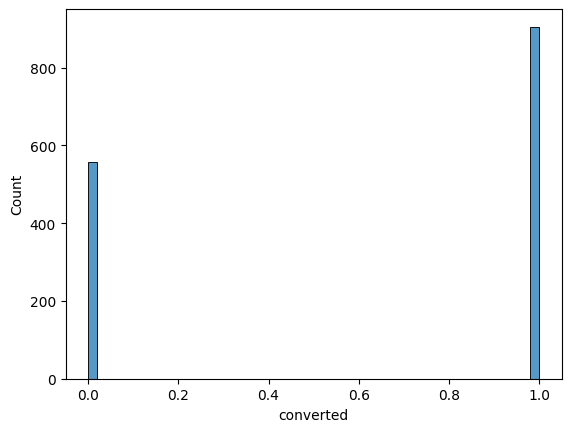

In [8]:
sns.histplot(cls_df[target_col], bins=50)

#### Define functions

In [16]:
# Split the dataset
def split_train_val_test(df, val_ratio=.2, test_ratio=.2, r_seed=42, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data.
    """
    n = len(df)
    # Generate test dataset
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=r_seed)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, random_state=r_seed)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
    return train_df, val_df, test_df

# Prepare X and y
def prepare_X_y(df, target_col="converted", verbose=False, label=" "):
    pdf = df.copy()
    y = pdf[target_col].values
    X = pdf.drop(columns=target_col).values
    if verbose:
        print(f"All {len(df)} rows in the{label}dataframe are contained within X and y: {len(X) == len(y) == len(df)}\n")
    return X, y


### Q1. Most common Industry

In [10]:
print(f"The most frequent observation (mode) for the industry column is {BOLD}{cls_df['industry'].mode()[0]}")

The most frequent observation (mode) for the industry column is retail


### Q2. Two most correlated features

In [11]:
cols_to_corr = ['interaction_count', 'lead_score', 'number_of_courses_viewed', 'annual_income']
cls_df_corr = cls_df[cols_to_corr].corr()
print(cls_df_corr)

                          interaction_count  lead_score  \
interaction_count                  1.000000    0.009888   
lead_score                         0.009888    1.000000   
number_of_courses_viewed          -0.023565   -0.004879   
annual_income                      0.027036    0.015610   

                          number_of_courses_viewed  annual_income  
interaction_count                        -0.023565       0.027036  
lead_score                               -0.004879       0.015610  
number_of_courses_viewed                  1.000000       0.009770  
annual_income                             0.009770       1.000000  


In [12]:
# Note the largest correlation matrix value is positive so no need to consider if negative correlation should be included...
max_corr_val = cls_df_corr.values[~np.eye(cls_df_corr.shape[0], dtype=bool)].max()
print(f"The two features that have the largest correlation are {BOLD}{cls_df_corr[cls_df_corr==max_corr_val].stack().idxmax()}")

The two features that have the largest correlation are ('interaction_count', 'annual_income')


### Split the data into train, validation, and test datasets
1. Split the data in train/val/test sets with 60%/20%/20% distribution
2. Use Scikit-Learn for splitting (the train_test_split function) and set the seed to 42

Make sure that the target value y is not in your dataframe.

In [17]:
train_df, val_df, test_df = split_train_val_test(cls_df, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True


### Q3. Categorical feature with largest mutual information score
- Calculate the mutual information score between y and the other categorical variables in the dataset
  1. Use the training set only
  2. Round the scores to 2 decimals using round(score, 2)

Which of these variables has the biggest mutual information score?

In [23]:
print(f"Which feature has the largest mutual information score? {BOLD}{None}")

Which feature has the largest mutual information score? None


### Q4. R with best RMSE
Train a regularized linear regression.
  1. Fill the NAs with 0
  2. Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100]
  3. Use RMSE to evaluate the model on the validation dataset. Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE? If there are multiple options, select the smallest r.

In [13]:
reg_vals = [0, 0.01, 0.1, 1, 5, 10, 100]
reg_val_rmse = []
for reg in reg_vals:
    print(f"\nEvaluating Linear Model Trained with R = {reg}\n")
    # Train model with horsepower NA values filled with 0
    X_train_hp0, y_train_hp0 = prepare_X_y(train_df, verbose=True, label=" training ")
    w0_hp0, w_hp0 = train_linear_regression(X_train_hp0, y_train_hp0, verbose=True, reg=reg)
    y_pred_train_hp0 = predict_y(X_train_hp0, w0_hp0, w_hp0)
    rmse_train_hp0 = compute_rmse(y_train_hp0, y_pred_train_hp0, round_flag=True, verbose=True, data_label="Training ", prep_label=" with HP NAs filled with 0")
    
    # Apply model to validation dataset with horsepower NA values filled with 0
    X_val_hp0, y_val_hp0 = prepare_X_y(val_df, verbose=True, label=" validation ")
    y_pred_val_hp0 = predict_y(X_val_hp0, w0_hp0, w_hp0)
    rmse_val_hp0 = compute_rmse(y_val_hp0, y_pred_val_hp0, round_flag=True, verbose=True, data_label="Validation ", prep_label=" with HP NAs filled with 0")
    reg_val_rmse.append(rmse_val_hp0)


Evaluating Linear Model Trained with R = 0

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 28.82736547365895, w = [ 9.93613218e-05  3.54221891e-03 -5.01328015e-03  3.42992870e-04]

Training RMSE with HP NAs filled with 0 = 0.52

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.52


Evaluating Linear Model Trained with R = 0.01

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 24.92683841981215, w = [ 0.00010643  0.0035422  -0.00501248  0.00228024]

Training RMSE with HP NAs filled with 0 = 0.52

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.52


Evaluating Linear Model Trained with R = 0.1

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 11

In [14]:
print(f"The smallest r value with the minimum RMSE = {BOLD}{reg_vals[reg_val_rmse.index(min(reg_val_rmse))]}")

The smallest r value with the minimum RMSE = 0


### Q5. Effect of different random seeds for splitting into train/validation/test datasets
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. For each seed,
  1. Split into train/validation/test datasets with 60%/20%/20% distribution, respectively
  2. Fill the missing values with 0 and train a model without regularization
  3. For each seed, evaluate the model on the validation dataset and collect the RMSE scores
  4. Compute the standard deviation of all the scores. Use np.std and round the result to 3 decimal digits (round(std, 3))

What's the value of std?

In [15]:
r_seed_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
r_seed_val_rmse = []
for r_seed in r_seed_vals:
    train_df, val_df, test_df = split_train_val_test(pp_df, val_ratio, test_ratio, r_seed, verbose=True)
    # Train model with horsepower NA values filled with 0
    X_train_hp0, y_train_hp0 = prepare_X_y(train_df, verbose=True, label=" training ")
    w0_hp0, w_hp0 = train_linear_regression(X_train_hp0, y_train_hp0, verbose=True)
    y_pred_train_hp0 = predict_y(X_train_hp0, w0_hp0, w_hp0)
    rmse_train_hp0 = compute_rmse(y_train_hp0, y_pred_train_hp0, verbose=True, data_label="Training ", prep_label=" with HP NAs filled with 0")
    
    # Apply model to validation dataset with horsepower NA values filled with 0
    X_val_hp0, y_val_hp0 = prepare_X_y(val_df, verbose=True, label=" validation ")
    y_pred_val_hp0 = predict_y(X_val_hp0, w0_hp0, w_hp0)
    rmse_val_hp0 = compute_rmse(y_val_hp0, y_pred_val_hp0, verbose=True, data_label="Validation ", prep_label=" with HP NAs filled with 0")
    r_seed_val_rmse.append(rmse_val_hp0)

rs_val_rmse_std = round(np.std(r_seed_val_rmse), 3)

All rows in the original dataframe are contained within the training, validation, or test datasets: True
All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 27.376388746528697, w = [ 0.00018021  0.00369662 -0.00500077  0.00102818]

Training RMSE with HP NAs filled with 0 = 0.5171560913636251

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.5206531296294218

All rows in the original dataframe are contained within the training, validation, or test datasets: True
All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 29.02246855416138, w = [ 9.11368124e-05  3.52555390e-03 -5.01868823e-03  2.57195231e-04]

Training RMSE with HP NAs filled with 0 = 0.5148529296311273

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.5213388

In [16]:
print(f"The standard deviation of the validation RMSE values for different train/validation/test split random seeds = {BOLD}{rs_val_rmse_std}")

The standard deviation of the validation RMSE values for different train/validation/test split random seeds = 0.007


### Q6. Final model RMSE on test dataset
1. Split the dataset like previously, use seed 9.
2. Combine train and validation datasets.
3. Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [17]:
tv_r_seed = 9
tv_reg = 0.001
train_df, val_df, test_df = split_train_val_test(pp_df, val_ratio, test_ratio, tv_r_seed, verbose=True)
train_val_df = pd.concat([train_df, val_df])
# Train model with horsepower NA values filled with 0
X_train_val, y_train_val = prepare_X_y(train_val_df, verbose=True, label=" training+validation ")
w0_tv, w_tv = train_linear_regression(X_train_val, y_train_val, reg=tv_reg, verbose=True)
y_pred_tv = predict_y(X_train_val, w0_tv, w_tv)
rmse_train_val = compute_rmse(y_train_val, y_pred_tv, verbose=True, data_label="Training+validation ", prep_label=" with HP NAs filled with 0")

# Apply model to validation dataset with horsepower NA values filled with 0
X_test, y_test = prepare_X_y(test_df, verbose=True, label=" test ")
y_pred_test = predict_y(X_test, w0_tv, w_tv)
rmse_test = compute_rmse(y_test, y_pred_test, verbose=True, data_label="Test ", prep_label=" with HP NAs filled with 0")

All rows in the original dataframe are contained within the training, validation, or test datasets: True
All 7764 rows in the training+validation dataframe are contained within X and y: True

Model parameters are as follows: w0 = 26.946834792836274, w = [ 1.45147512e-05  3.56475200e-03 -5.01712541e-03  1.29155334e-03]

Training+validation RMSE with HP NAs filled with 0 = 0.5197448026201177

All 1940 rows in the test dataframe are contained within X and y: True

Test RMSE with HP NAs filled with 0 = 0.5156261299169602



In [18]:
print(f"The RMSE for the test dataset = {BOLD}{rmse_test}")

The RMSE for the test dataset = 0.5156261299169602


### Extra Credit

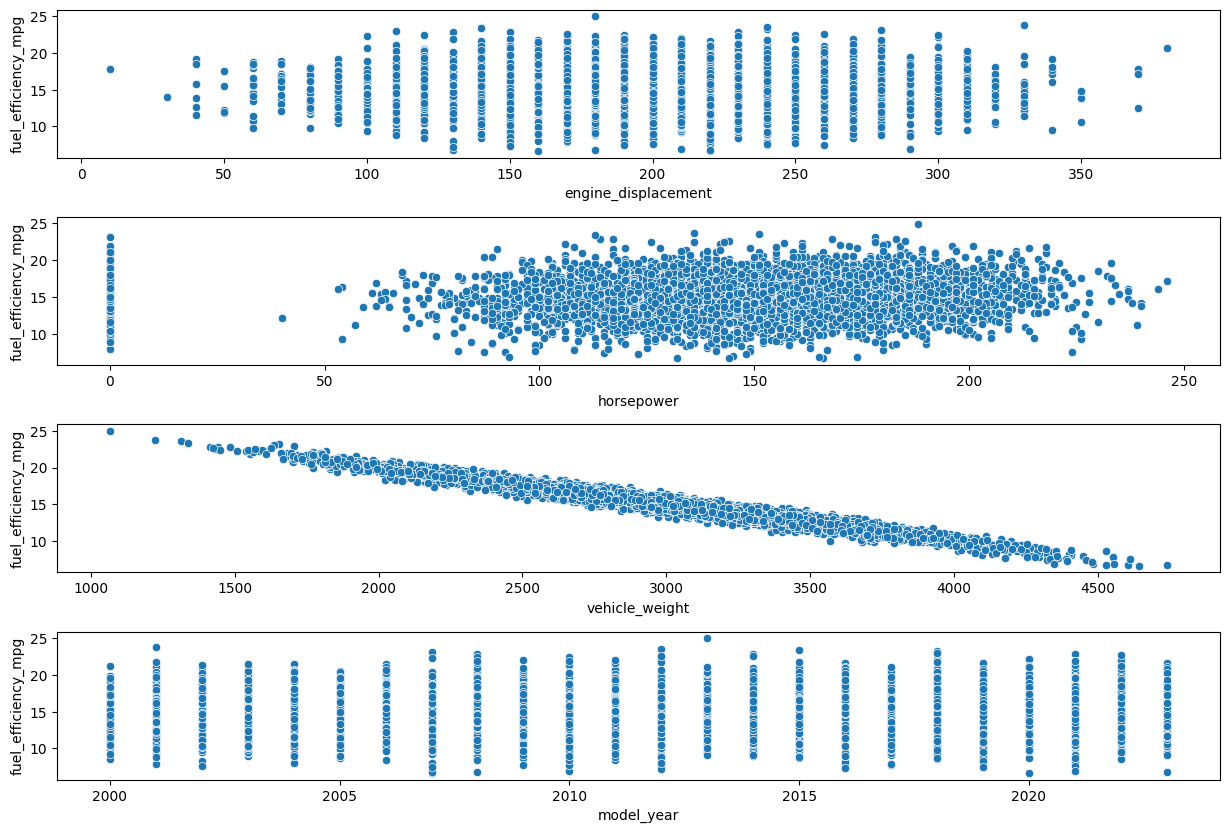

In [19]:
# Let's plot how each feature fits the target variable
n_feat = X_train_hp0.shape[1]
X_col_names = list(train_df.drop(columns=target_col).columns)

fig, axes = plt.subplots(n_feat, 1, figsize=(15, 10))
for f in range(n_feat):
    sns.scatterplot(x=X_train_hp0[:, f], y=y_train_hp0, ax=axes[f])
    axes[f].set_xlabel(X_col_names[f])
    axes[f].set_ylabel(target_col)
plt.subplots_adjust(hspace=0.4)